# Tour of New Harmony Services
## PI 21.4 Solution Demonstration

Outline:
1. Segmented Trajectory Subsetter in support of GEDI and ICESat-2 data: Owen Littlejohns, Data Services 
2. Data aggregation: PO.DAAC CONCISE service: Frank Greguska and Stepheny Perez, PO.DAAC TVA
3. Cloud Optimized GeoTIFF (COG) reformatting: Frank Greguska, PO.DAAC TVA
4. Zarr customized chunking: Hailiang Zhang, Harmony

Requirements:
* .netrc created with both UAT and PROD EDL credentials
* The notebook was run using the Openscapes python environment copied from a Cloud Hackathon user: https://github.com/eeholmes/jupyterhub/blob/main/environment.yml. You must run this notebook in-place in the `us-west-2` region in order for the AiP workflows to run successfully.

## Import Packages

In [31]:
# Shared libraries
from harmony import BBox, Client, Collection, Environment, Request, LinkType
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

# Concise demo
import s3fs
import tempfile
from IPython.display import display, JSON
from datetime import datetime
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
%matplotlib inline

#COG demo
from pprint import pprint
import boto3
import rioxarray
import rasterio as rio
from rasterio.session import AWSSession
from rasterio.plot import show
import hvplot.xarray
import os
import holoviews as hv

#Zarr chunking demo
import fsspec

___ 
# Trajectory Subsetter demo example requests

The scope of this notebook is to provide example requests for the PI 21.4 Harmony services Inspect and Adapt deomonstrations. This will include:

* Variable subsetting.
* Temporal subsetting.
* Bounding box spatial subsetting.
* Polygon spatial subsetting (EDSC instructions).

Distinctions from other services:

* Works on trajectory, rather than swath data.
* Preserves continuity of photon segment indices.
* Configured for Cloud-hosted GEDI L4A test collection.

### Set up imports and variables

In [32]:
from datetime import datetime
from os import replace

from harmony import BBox, Client, Collection, Environment, Request
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


gedi_l4a = Collection(id='C1242267295-EEDTEST')
file_root_name = 'GEDI_L4A'
variables = ['/BEAM0000/agbd', '/BEAM0000/delta_time', '/BEAM0000/lat_lowestmode', '/BEAM0000/lon_lowestmode']
granule_id = 'G1242274838-EEDTEST'
temporal_range = {'start': datetime(2020, 7, 25, 1, 0, 0), 'stop': datetime(2020, 7, 25, 2, 0, 0)}
bounding_box = BBox(w=-120, s=45, e=-100, n=55)

harmony_client = Client(env=Environment.UAT)

### Helper functions:

In [33]:
def print_all_variables(dataset):
    """ A helper function to traverse all groups in a file and
        print the variables present, along with their sizes.

    """
    print('\nVariables present:\n')
    for group in dataset.groups.values():
        for variable in group.variables.values():
            print(f'{group.path}/{variable.name}, {variable.shape}')
    print('\n')


def get_geo_plot_fig_and_ax(extents):
    """ A helper function to retrieve the figure and axes for a plot
        showing landmasses, oceans and country borders.

    """
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent(extents, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)
    return fig, ax

### Variable subsetting:

The GEDI L4A collection has granules that are at least 1 GB in size. The Trajectory Subsetter provides the capability to perform a variable subset, to reduce the size of the output product. The variable subset will include:

* `/BEAM0000/agbd`, above ground biomass density.
* `/BEAM0000/delta_time`, the temporal coordinate for the science variable.
* `/BEAM0000/lat_lowestmode`, the latitude coordinate for the science variable.
* `/BEAM0000/lon_lowestmode`, the longitude coordinate for the science variable.

In [67]:
variable_subset_request = Request(collection=gedi_l4a, variables=variables, max_results=1,
                                  granule_id=[granule_id])
variable_subset_job_id = harmony_client.submit(variable_subset_request)
variable_local_file_name = f'{file_root_name}_variable.h5'

print(f'Processing job: {variable_subset_job_id}')

url = list(harmony_client.result_urls(variable_subset_job_id))[0]
filename = harmony_client.download(url, overwrite=True).result()
print(f'Downloaded: {filename}')

        
replace(filename, variable_local_file_name)
print(f'Saved output to: {variable_local_file_name}')

Processing job: f7f2382a-f2e8-4311-944d-66de046f0a26
Downloaded: GEDI04_A_2020207012314_O09157_T05052_02_001_01_subsetted.h5
Saved output to: GEDI_L4A_variable.h5


### Checking the output:


Variables present:

/BEAM0000/agbd, (461173,)
/BEAM0000/delta_time, (461173,)
/BEAM0000/lat_lowestmode, (461173,)
/BEAM0000/lon_lowestmode, (461173,)




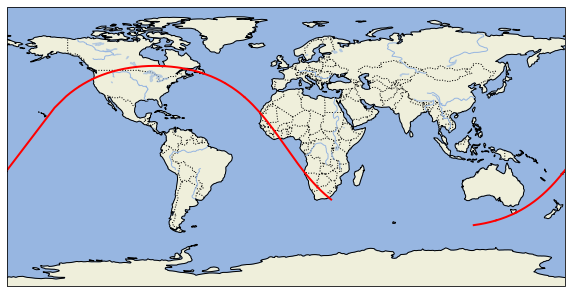

In [68]:
fig, ax = get_geo_plot_fig_and_ax([-180, 180, -90, 90])

with Dataset(variable_local_file_name, 'r') as variable_dataset:
    print_all_variables(variable_dataset)
    variable_latitude = variable_dataset['/BEAM0000/lat_lowestmode'][:]
    variable_longitude = variable_dataset['/BEAM0000/lon_lowestmode'][:]

plt.plot(variable_longitude, variable_latitude, color='red', linewidth=2, transform=ccrs.Geodetic())

### Temporal subsetting:

The Trajectory Subsetter accepts a single temporal range. In the request below, the temporal subset has been combined with a variable subset to maintain a small output product.

The temporal range specified is from 2020-07-25T01:00:00 to 2020-07-25T02:00:00.

In [69]:
temporal_subset_request = Request(collection=gedi_l4a, temporal=temporal_range, max_results=1,
                                  variables=variables, granule_id=[granule_id])
temporal_subset_job_id = harmony_client.submit(temporal_subset_request)
temporal_local_file_name = f'{file_root_name}_temporal.h5'

print(f'Processing job: {temporal_subset_job_id}')

url = list(harmony_client.result_urls(temporal_subset_job_id))[0]
filename = harmony_client.download(url, overwrite=True).result()
print(f'Downloaded: {filename}')

replace(filename, temporal_local_file_name)
print(f'Saved output to: {temporal_local_file_name}')

Processing job: 2638a102-1425-4a82-94c5-dd11ca89f559
Downloaded: GEDI04_A_2020207012314_O09157_T05052_02_001_01_subsetted.h5
Saved output to: GEDI_L4A_temporal.h5


### Checking the output:


Variables present:

/BEAM0000/agbd, (139965,)
/BEAM0000/delta_time, (139965,)
/BEAM0000/lat_lowestmode, (139965,)
/BEAM0000/lon_lowestmode, (139965,)




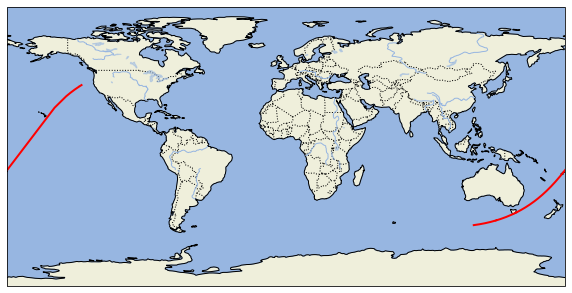

In [70]:
fig, ax = get_geo_plot_fig_and_ax([-180, 180, -90, 90])

with Dataset(temporal_local_file_name, 'r') as temporal_dataset:
    print_all_variables(temporal_dataset)
    temporal_latitude = temporal_dataset['/BEAM0000/lat_lowestmode'][:]
    temporal_longitude = temporal_dataset['/BEAM0000/lon_lowestmode'][:]

plt.plot(temporal_longitude, temporal_latitude, color='red', linewidth=2, transform=ccrs.Geodetic())

### Bounding box spatial subsetting:

The Trajectory Subsetter accepts a single bounding box. The request below combines a bounding box with a variable subset to maintain a small output product.

The bounding box specified is:

* 10 ≤ latitude (degrees north) ≤ 30
* 10 ≤ longitude (degrees east) ≤ 30

Things to check in output:

* The four requested variables are present in the output.
* The variables all have the same size, which should be smaller than the variable subset only.
* The `/BEAM0000/lat_lowestmode` only has values in the range of the bounding box.
* The `/BEAM0000/lon_lowestmode` only has values in the range of the bounding box.

In [71]:
bbox_subset_request = Request(collection=gedi_l4a, spatial=bounding_box, max_results=1,
                              granule_id=[granule_id], variables=variables)
bbox_subset_job_id = harmony_client.submit(bbox_subset_request)
bbox_local_file_name = f'{file_root_name}_bbox.h5'

print(f'Processing job: {bbox_subset_job_id}')

url = list(harmony_client.result_urls(bbox_subset_job_id))[0]
filename = harmony_client.download(url, overwrite=True).result()
print(f'Downloaded: {filename}')
    
replace(filename, bbox_local_file_name)
print(f'Saved output to: {bbox_local_file_name}')

Processing job: 49323a5d-83d3-4b21-b654-14148ca71996
Downloaded: GEDI04_A_2020207012314_O09157_T05052_02_001_01_subsetted.h5
Saved output to: GEDI_L4A_bbox.h5


### Checking the results


Variables present:

/BEAM0000/agbd, (27742,)
/BEAM0000/delta_time, (27742,)
/BEAM0000/lat_lowestmode, (27742,)
/BEAM0000/lon_lowestmode, (27742,)




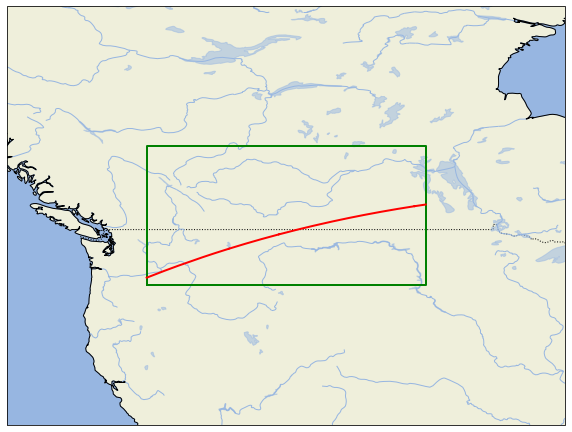

In [72]:
fig, ax = get_geo_plot_fig_and_ax([-130, -90, 35, 65])

with Dataset(bbox_local_file_name, 'r') as bbox_dataset:
    print_all_variables(bbox_dataset)
    bbox_latitude = bbox_dataset['/BEAM0000/lat_lowestmode'][:]
    bbox_longitude = bbox_dataset['/BEAM0000/lon_lowestmode'][:]

bbox_longitudes = [bounding_box.w, bounding_box.w, bounding_box.e, bounding_box.e, bounding_box.w]
bbox_latitudes = [bounding_box.s, bounding_box.n, bounding_box.n, bounding_box.s, bounding_box.s]

plt.plot(bbox_longitudes, [45, 55, 55, 45, 45], color='green', linewidth=2, transform=ccrs.Geodetic())
plt.plot(bbox_longitude, bbox_latitude, color='red', linewidth=2, transform=ccrs.Geodetic())

### Polygon spatial subsetting:

The Trajectory Subsetter can accept a GeoJSON shape file to perform polygon spatial subsetting.

This request is best demonstrated via Earthdata Search Client (EDSC).

* Navigate to EDSC (UAT).
* Load a GeoJSON shape file using the filters in the left toolbar (Egypt shape file should be distributed with this notebook).
* Search for "GEDI L4A EEDTEST".
* Select the collection. Then one of the granules that passes through the Egypt GeoJSON.
* Click "Download (1)".
* In the download customisation form:
  * Select Harmony ("More Info" should show "sds-trajectory-subsetter").
  * Ensure the four variables are selected (to maintain a small output).
  * Mention that the shape file is automatically sent in the Harmony request.
* Click "Download Data".
* Things to check in output:
  * The four requested variables are present in the output file.
  * The variables all have the same size (which should be smaller than the variable subset only).
  * The `/BEAM0000/lat_lowestmode` should be only within Egypt, approximately: 22.0 ≤ latitude (degrees north) ≤ 31.6.
  * The `/BEAM0000/lon_lowestmode` should be only within Egypt, approximately: 24.6 ≤ longitude (degrees east) ≤ 35.8.

___
# Cloud Optimized GeoTIFF reformatting

## Request COG using Harmony-py 

First, we need to create a Harmony Client, which is what we will interact with to submit and inspect a data request to Harmony, as well as to retrieve results.

When creating the Client, we need to provide Earthdata Login credentials, which are required to access data from NASA EOSDIS. This basic line below assumes that we have a `.netrc` available. 

In [73]:
harmony_client = Client(env=Environment.UAT)

We are working with the ECCO Atmosphere Surface Temperature, Humidity, Wind, and Pressure - Daily Mean 0.5 Degree (Version 4 Release 4) collection, looking at a single global granule from 2017-12-15:

In [74]:
concept_id = 'C1239379702-POCLOUD'
granuleid = 'G1241058382-POCLOUD'

Set up Harmony request, specifying the `EXFatemp` variable and `image/tiff` format, which will provide a Cloud-Optimized GeoTIFF output:

In [75]:
request = Request(
    collection=Collection(id=concept_id),
    granule_id=granuleid,
    variables=['EXFatemp'],
    format='image/tiff'
)

Submit request:

In [76]:
job_id = harmony_client.submit(request)
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


### While we're waiting... Why COGs?

* The  main benefit of this format over traditional GeoTIFF is that the files are structured in such a way that allows for partial-file access instead of needing to download the entire file. In other words, smaller chunks of the TIFF can be accessed individually, which can enable parallel processing from multiple threads.
* See https://www.cogeo.org/in-depth.html for an overview of the Tiling and Overviews organization techniques of the COG format to enable this enhanced read performance.

## Access COG output in-place from Harmony
Retrieve s3 URL:

In [77]:
results = harmony_client.result_urls(job_id, link_type=LinkType.s3)
cog_s3_url = list(results)
cog_s3_url

['s3://harmony-uat-staging/public/asfdataservices/gdal-subsetter/f71c630b-fa68-472a-8f5c-4794b8a55fc5/ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2017-12-15_ECCO_V4r4_latlon_0p50deg_EXFatemp.tif']

Access AWS credentials for the Harmony bucket:

In [78]:
creds = harmony_client.aws_credentials()

Credit to Aaron Friesz from LP.DAAC for the following step to configure the `boto3` session and configure our `rasterio` environment for data access:

In [79]:
session = boto3.Session(aws_access_key_id=creds['aws_access_key_id'], 
                        aws_secret_access_key=creds['aws_secret_access_key'],
                        aws_session_token=creds['aws_session_token'],
                        region_name='us-west-2')

Open up a context manager using the `rasterio.env` module to store the required GDAL and AWS configurations we need to access the data in Earthdata Cloud:

In [80]:
rio_env = rio.Env(AWSSession(session),
                  GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                  GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/cookies.txt'),
                  GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/cookies.txt'))
rio_env.__enter__()

#### Open and plot s3 object using `rioxarray` and `hvplot`:

In [81]:
da = rioxarray.open_rasterio(cog_s3_url[0], chunks=True)
da

<xarray.DataArray (band: 4, y: 360, x: 720)>
dask.array<open_rasterio-202bdf9742c836cd986842e15744a98e<this-array>, shape=(4, 360, 720), dtype=uint8, chunksize=(1, 360, 720), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * y            (y) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    spatial_ref  int64 0
Attributes:
    bandname:       ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2017-12-15_ECCO_V...
    long_name:      ('ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2017-12-15_ECCO...
    standard_name:  ATM_SURFACE_TEMP_HUM_WIND_PRES_day_mean_2017-12-15_ECCO_V...
    scale_factor:   1.0
    add_offset:     0.0

In [82]:
da.hvplot.rgb(x='x', y='y', bands='band', data_aspect=1, xaxis=False, yaxis=None)

:RGB   [x,y]   (R,G,B)

___
# Harmony Concise + L2SS-Py Demo

## What is Concise?
Concise is a Harmony service developed by PODAAC that allows users to concatenate multiple L2 granules together into a single granule. This concatenation is done by adding a new `subset_index` dimension to the resulting granule.

## What is L2SS-Py + Concise?
Harmony supports chaining multiple services together. The L2SS-Py + Concise chain allows users to combine spatial, temporal, and variable subsetting with granule concatenation.


## Before you start

Before you beginning this tutorial, make sure you have an account in the Earthdata Login UAT or Production environment, which will be used for this notebook by visiting https://uat.urs.earthdata.nasa.gov. These accounts, as all Earthdata Login accounts, are free to create and only take a moment to set up.


## Set Up Authentication

We need some boilerplate up front to log in to Earthdata Login. The function below will allow Python scripts to log into any Earthdata Login application programmatically. To avoid being prompted for credentials every time you run and also allow clients such as curl to log in, you can add the following to a .netrc (_netrc on Windows) file in your home directory:

machine uat.urs.earthdata.nasa.gov login password

machine urs.earthdata.nasa.gov login password Make sure that this file is only readable by the current user or you will receive an error stating "netrc access too permissive."

`$ chmod 0600 ~/.netrc`


Create Harmony-py client:

In [12]:
harmony_client = Client(env=Environment.PROD)

Contruct and validate Harmony request. This is a subsetting + concatenation request, so we are requesting both a spatial subset, variable subset, and concatenation request. 

In [13]:
collection = Collection(id='C2075141559-POCLOUD')

request = Request(
    collection=collection,
    spatial=BBox(-180, -90, 0, 0),
    variables=[
        'wind_speed', 
        'wind_dir'
    ],
    concatenate=True,
    max_results=5,
)

request.is_valid()

True

Submit Harmony job

In [14]:
job_id = harmony_client.submit(request)

Retrieve Harmony job status using job ID

In [15]:
harmony_client.status(job_id)

{'status': 'running',
 'message': 'CMR query identified 47566 granules, but the request has been limited to process only the first 5 granules because you requested 5 maxResults.',
 'progress': 0,
 'created_at': datetime.datetime(2022, 1, 3, 21, 33, 9, 548000, tzinfo=tzlocal()),
 'updated_at': datetime.datetime(2022, 1, 3, 21, 33, 9, 548000, tzinfo=tzlocal()),
 'request': 'https://harmony.earthdata.nasa.gov/C2075141559-POCLOUD/ogc-api-coverages/1.0.0/collections/wind_speed,wind_dir/coverage/rangeset?forceAsync=true&subset=lat(-90%3A0)&subset=lon(-180%3A0)&maxResults=5&concatenate=true',
 'num_input_granules': 5}

Wait until the Harmony request has finished processing. This is a blocking call.

In [16]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


Retrieve single output s3 location: 

In [17]:
results = harmony_client.result_urls(job_id, link_type=LinkType.s3)
s3_urls = list(results)
pprint(s3_urls)

['s3://harmony-prod-staging/public/podaac/l2-subsetter-concise/86f60e17-baad-4ce2-8a6b-c10486019e40/C2075141559-POCLOUD_merged.nc4']


#### AWS credential retrieval
Using aws_credentials you can retrieve the credentials needed to access the Harmony s3 staging bucket and its contents.

In [18]:
creds = harmony_client.aws_credentials()

#### Open staged files with *s3fs* and *xarray*

We use the AWS `s3fs` package to create a file system that can then be read by xarray:

In [19]:
s3_fs = s3fs.S3FileSystem(
    key=creds['aws_access_key_id'],
    secret=creds['aws_secret_access_key'],
    token=creds['aws_session_token'],
    client_kwargs={'region_name':'us-west-2'},
)

Now that we have our s3 file system set, including our declared credentials, we'll use that to open the url, and read in the file through xarray.

Open concatenated granule using xarray. Notice the variable subset has been successfully executed -- only `wind_dir` and `wind_speed` vars are present.

In [20]:
f = s3_fs.open(s3_urls[0], mode='rb')
ds = xr.open_dataset(f, decode_times=False)
ds

<xarray.Dataset>
Dimensions:       (subset_index: 5, NUMROWS: 704, NUMCELLS: 42)
Coordinates:
    lat           (subset_index, NUMROWS, NUMCELLS) float32 ...
    lon           (subset_index, NUMROWS, NUMCELLS) float32 ...
Dimensions without coordinates: subset_index, NUMROWS, NUMCELLS
Data variables:
    subset_files  (subset_index) object ...
    time          (subset_index, NUMROWS, NUMCELLS) float64 ...
    wind_speed    (subset_index, NUMROWS, NUMCELLS) float32 ...
    wind_dir      (subset_index, NUMROWS, NUMCELLS) float32 ...
Attributes: (12/22)
    title:                            MetOp-B ASCAT Level 2 25.0 km Ocean Sur...
    title_short_name:                 ASCATB-L2-25km
    Conventions:                      CF-1.4
    institution:                      EUMETSAT/OSI SAF/KNMI
    source:                           MetOp-B ASCAT
    software_identification_level_1:  [801]
    ...                               ...
    rev_orbit_period:                 6081.7
    orbit_inclination:                98.7
    references:                       ASCAT Wind Product User Manual, http://...
    comment:                          Orbit period and inclination are consta...
    creation_date:                    2013-06-10
    history_json:                     [{"date_time": "2022-01-03T21:33:16.565...

For each granule that makes up this concatenated granule, plot `wind_speed` for that granule using `subset_index` dimension.

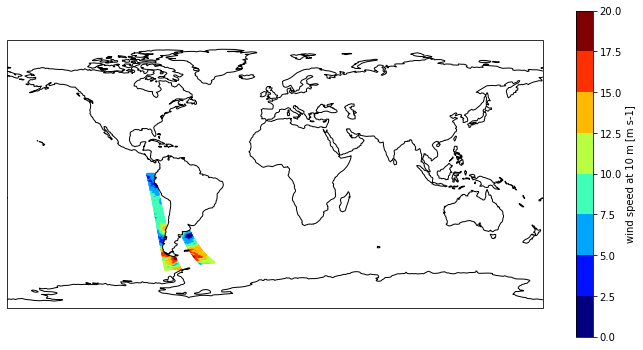

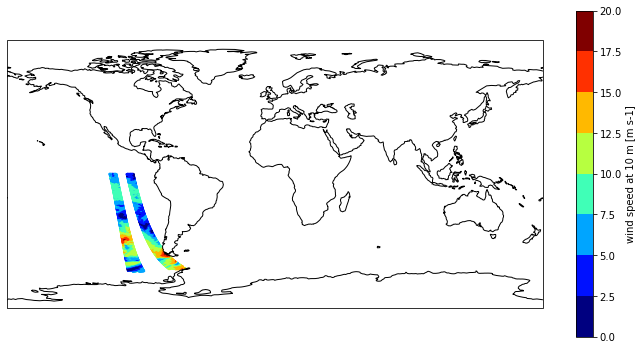

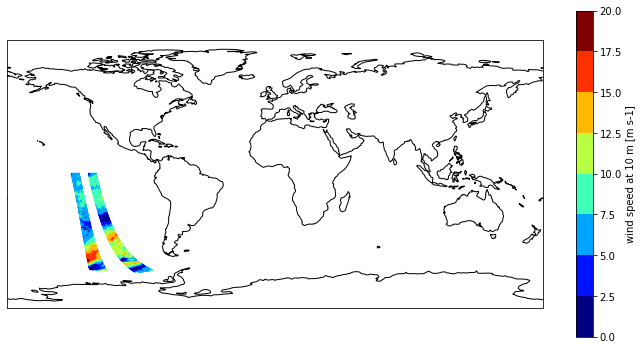

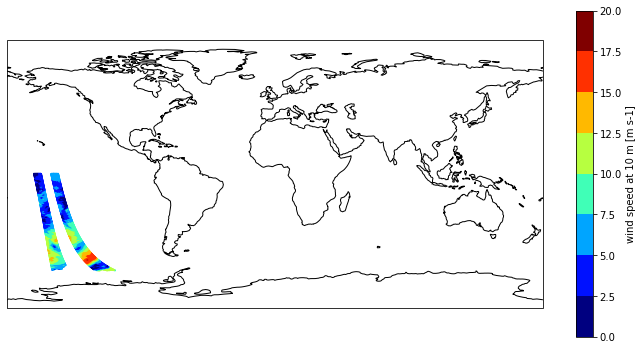

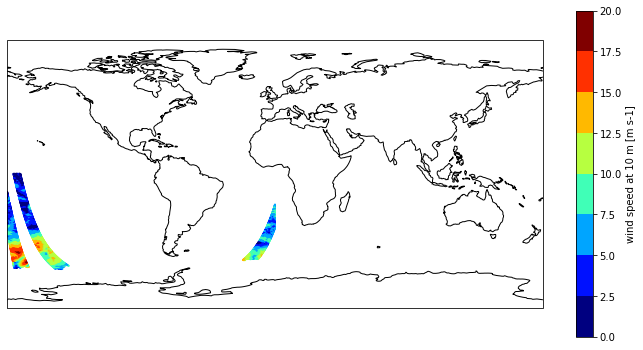

In [21]:
for index in range(0, 5):   
    plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())

    p = ds.isel(subset_index=index).plot.scatter(
        y="lat",
        x="lon",
        hue="wind_speed",
        s=1,
        levels=9,
        cmap="jet",
        ax=ax
    )
    
    ax.set_global()
    ax.coastlines()
    plt.show()

Plot `wind_speed` for all data in this concatenated granule. Notice that the data is within the spatial bounds we provided earlier (-180,-90,0,0)

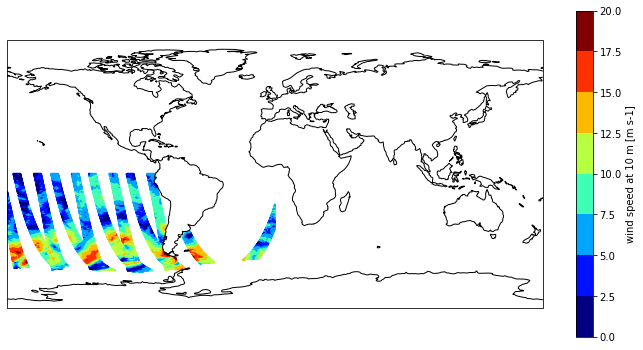

In [22]:
plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

p = ds.plot.scatter(
    y="lat",
    x="lon",
    hue="wind_speed",
    s=1,
    levels=9,
    cmap="jet",
    ax=ax
)

ax.set_global()
ax.coastlines()
plt.show()

___
# Zarr Customized Chunking

### About chunking

https://www.unidata.ucar.edu/software/netcdf/workshops/2011/nc4chunking/WhatIsChunking.html

A chunk is a hyper-rectangle of any shape.

When a dataset is chunked, each chunk is read or written as a single I/O operation, and individually passed from stage to stage of the pipeline and filters.


<img src="images/chunked.png" width=380 />

###  Chunking in harmony netcdf-to-zarr service

<img src="images/dist.png" width=800/>

### A harmony netcdf-to-zarr request

SMAP L4 Global Daily 9 km EASE-Grid Carbon Net Ecosystem Exchange V005

### Chunksize after netcdf-to-zarr conversion

Request data using Harmony-py:

In [83]:
harmony_client = Client(env=Environment.UAT)

request = Request(
    collection=Collection(id='C1240150677-EEDTEST'),
    format='application/x-zarr',
    max_results=1
)

Submit request:

In [84]:
job_id = harmony_client.submit(request)
job_id

'91a741af-3221-4dfb-af0b-f550450e6648'

Wait until the Harmony request has finished processing:

In [85]:
harmony_client.wait_for_processing(job_id, show_progress=True)

 [ Processing: 100% ] |###################################################| [|]


Retrieve s3 url:

In [86]:
results = harmony_client.result_urls(job_id, link_type=LinkType.s3)
s3_url = list(results)
s3_url

['s3://harmony-uat-staging/public/harmony/netcdf-to-zarr/a6dc30a7-ea2f-42e2-9879-4fc09fd27394/SMAP_L4_C_mdl_20210212T000000_Vv5024_001.zarr']

#### AWS credential retrieval
Using aws_credentials you can retrieve the credentials needed to access the Harmony s3 staging bucket and its contents.

In [87]:
creds = harmony_client.aws_credentials()

#### Open staged files with *s3fs* and *xarray*

We use the AWS `s3fs` package to create a file system that can then be read by xarray:

In [88]:
s3_fs = s3fs.S3FileSystem(
    key=creds['aws_access_key_id'],
    secret=creds['aws_secret_access_key'],
    token=creds['aws_session_token'],
    client_kwargs={'region_name':'us-west-2'},
)

Create zarr store using S3Map:

In [89]:
zarr_store = s3fs.S3Map(root=s3_url[0], s3=s3_fs, check=False)

Open Zarr store with optimized chunking in `xarray`:

In [90]:
ds = xr.open_zarr(store=zarr_store, group='/SOC', consolidated=True)['soc_mean']
ds

<xarray.DataArray 'soc_mean' (y: 1624, x: 3856)>
dask.array<open_dataset-6f7f508c107017c4a5fd67c101cdebafsoc_mean, shape=(1624, 3856), dtype=float64, chunksize=(1402, 1402), chunktype=numpy.ndarray>
Dimensions without coordinates: y, x
Attributes:
    DIMENSION_LABELS:  ['y', 'x']
    coordinates:       GEO/latitude GEO/longitude
    grid_mapping:      EASE2_global_projection
    long_name:         Global daily 9km soil organic carbon mean.
    observed_max:      32800.328125
    observed_mean:     2300.927490234375
    observed_min:      51.83123016357422
    short_name:        soc_mean
    units:             gCm^-2
    valid_max:         25000.0
    valid_min:         0.0
    vmax:              25000.0
    vmin:              0.0